<a href="https://colab.research.google.com/github/panditamey/DiabeticRetinopathy/blob/main/DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                             Spotify and Youtube                                 9MB  2023-03-20 15:43:25           6980        262  1.0              
ppb00x/country-gdp                                                Country_GDP                                         7KB  2023-04-07 06:47:36            684         25  1.0              
erdemtaha/cancer-data                                             Cancer Data                                        49KB  2023-03-22 07:57:00           2648         67  1.0              
omartorres25/honda-data                                     

In [3]:
!kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged

 99% 1.20G/1.21G [00:11<00:00, 126MB/s]
100% 1.21G/1.21G [00:11<00:00, 108MB/s]


In [4]:
!mkdir dataset

In [5]:
!unzip diabetic-retinopathy-resized-arranged.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/2/23798_right.jpeg  
  inflating: dataset/2/23817_left.jpeg  
  inflating: dataset/2/23817_right.jpeg  
  inflating: dataset/2/23821_left.jpeg  
  inflating: dataset/2/23821_right.jpeg  
  inflating: dataset/2/23852_left.jpeg  
  inflating: dataset/2/23854_left.jpeg  
  inflating: dataset/2/23905_left.jpeg  
  inflating: dataset/2/23905_right.jpeg  
  inflating: dataset/2/23906_left.jpeg  
  inflating: dataset/2/23923_left.jpeg  
  inflating: dataset/2/23923_right.jpeg  
  inflating: dataset/2/23946_left.jpeg  
  inflating: dataset/2/23946_right.jpeg  
  inflating: dataset/2/23961_left.jpeg  
  inflating: dataset/2/23961_right.jpeg  
  inflating: dataset/2/23967_left.jpeg  
  inflating: dataset/2/23967_right.jpeg  
  inflating: dataset/2/239_left.jpeg  
  inflating: dataset/2/239_right.jpeg  
  inflating: dataset/2/24064_left.jpeg  
  inflating: dataset/2/24064_right.jpeg  
  inflating: dataset/2/24074_left.jpeg  


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.applications import MobileNetV2

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as lyrs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

root="/content/dataset"
IMG_SIZE=224

In [7]:
#View Random Image
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)
    
#Pre-processing the Image
def pre_process_image(path, image_shape=224, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

#Testing Image Classification Model
def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))
    
    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)
    
    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path)) 
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]
        
    '''Visualize'''
    plt.imshow(random_image)
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder)
    plt.show()
    
#Plot Loss and Accuracy curve for the given Model
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]
    
    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
#Confusion Matrix for Classification
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

#Supervised Learning Meterics
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

In [8]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="training",
    seed=42,
)

test_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 28103 images belonging to 5 classes.
Found 7023 images belonging to 5 classes.


In [9]:
import tensorflow as tf
import tensorflow_hub as hub

In [10]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3), trainable=False)

In [11]:
model_base = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

#Transfer Learning Model
inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.Dropout(0.5)(x)
outputs=lyrs.Dense(5, activation="softmax", 
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                

In [ ]:
checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4), metrics=["accuracy"])
model_history=model.fit(x=train_datagen, 
         steps_per_epoch=64,
         validation_data=test_datagen,
         epochs=20,
         callbacks=[checkpointer, early_stopping])

In [ ]:
loss_curve_plot(model_history)

In [14]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model.h5')

In [ ]:
labels=test_datagen.classes
model=tf.keras.models.load_model("/content/model.h5")
y_pred=model.predict(test_datagen)
prediction=tf.math.round(y_pred).numpy()
prediction=prediction.argmax(axis=1)

supervised_metrics(labels, prediction)

In [ ]:
confusion_matrix_plot(labels, prediction, figsize=(10,10))


In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [18]:
model_loaded=load_model('model.h5')

In [28]:
img=image.load_img('/content/dataset/4/10321_left.jpeg',target_size=(224,224))


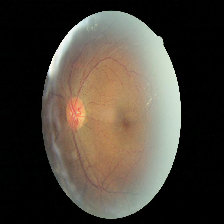

In [29]:
img

In [30]:
x=image.img_to_array(img)
x = x.reshape(224,224,3)
x.shape

(224, 224, 3)

In [31]:
x=x/255

In [32]:
x=np.expand_dims(x,axis=0)


In [33]:
prediction = model.predict(x)
predictions = list(prediction[0])

1/1 [==============================] - 0s 24ms/step


In [34]:
print(predictions)

[0.8914747, 0.05600895, 0.051574305, 0.00046304704, 0.00047890117]


In [36]:
classes = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
a=np.argmax(model.predict(x), axis=1)
print(classes[a[0]])

1/1 [==============================] - 0s 38ms/step
No DR


1/1 [==============================] - 0s 29ms/step


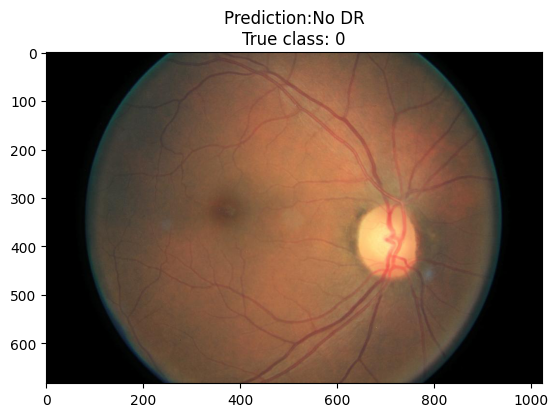

In [46]:
random_tester(root, 
  ["No DR","Mild","Moderate","Severe","Proliferative DR"]
, model, class_type="multi")